<a href="https://colab.research.google.com/github/plaban1981/Hugging_Face_transformers_topics/blob/main/Content_Based_Image_Search_InstructBLIP_%2B_Sentence_Transformers_%2B_FAISS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git accelerate bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.7 MB/s eta 0:00:00


In [3]:
!pip install -qU datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.1 MB/s eta 0:00:00


In [4]:
import torch
from datasets import load_dataset
from transformers import InstructBlipProcessor,InstructBlipForConditionalGeneration

In [5]:
model = InstructBlipForConditionalGeneration.from_pretrained("Salesforce/instructblip-vicuna-7b",
                                                             load_in_4bit=True,
                                                             torch_dtype = torch.bfloat16,)
#
processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-vicuna-7b")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
datasets = [
    ("detection-datasets/fashionpedia",None,"val"),
    ("keremberke/nfl-object-detection","mini","test"),
    ("keremberke/nplane-detection","mini","train"),
    ("Matthijs/snacks",None,"validation"),
    ("rokmr/mini_pets",None,"test"),
    ("keremberke/pokemon-classification","mini","train"),
]

In [7]:
prompt_1 = """Describe this image in full detail.describe each and every aspect of the image"""
prompt_2 = """Create an extensive description of the image"""

In [10]:
counter = 0
for name,config,split in datasets:
  d = load_dataset(name,config,split=split)
  for idx in range(len(d)):
    image  = d[idx]["image"]
    desc = ""
    for _prompt in [prompt_1,prompt_2]:
      inputs = processor(images=image,
                         text=_prompt,
                         return_tensors="pt"
                         ).to(model.device,torch.bfloat16)
      outputs = model.generate(**inputs,
                               do_sample=False,
                               num_beams=10,
                               max_length=512,
                               min_length=16,
                               top_p=0.9,
                               repetition_penalty=1.5,
                               temperature=1,
                               )
      generated_text = processor.batch_decode(outputs,skip_special_tokens=True)[0].strip()
      desc += generated_text + " "
      desc = desc.strip()
      image.save(f"images_{counter}.jpg")
      print(counter,desc)
      #
      with open("description.csv","w") as f:
        f.write(f"{counter},{desc}\n")
      counter += 1
      torch.cuda.empty_cache()

0 The image features a well-dressed man wearing a suit, bow tie, and sunglasses. He is standing in front of a yellow door, looking confidently into the camera.  In addition to the man, there are several potted plants scattered throughout the image, adding a natural touch to the scene. There are two potted plants on the left side of the image, one close to the man and another slightly further away. Another potted plant can be seen on the right side of the image, closer to the yellow door.
1 The image features a well-dressed man wearing a suit, bow tie, and sunglasses. He is standing in front of a yellow door, looking confidently into the camera.  In addition to the man, there are several potted plants scattered throughout the image, adding a natural touch to the scene. There are two potted plants on the left side of the image, one close to the man and another slightly further away. Another potted plant can be seen on the right side of the image, closer to the yellow door.a man with a be

KeyboardInterrupt: ignored

In [15]:
import pandas as pd
df = pd.read_csv("/content/description.csv",delimiter="\t")

In [16]:
df.head()

,"41,The image depicts a fashion show taking place on a runway. A beautiful blonde woman is walking confidently down the runway, wearing a pink bomber jacket and a skirt. She is surrounded by a group of people who appear to be attending the fashion show. In total, there are 15 people visible in the image, ranging from close-up shots of the woman on the runway to more distant views of the audience. Additionally, there are several chairs scattered throughout the scene, providing seating for the attendees. Overall, the image captures the energy and excitement of a vibrant fashion event.a woman walking down a runway wearing a pink jacket"


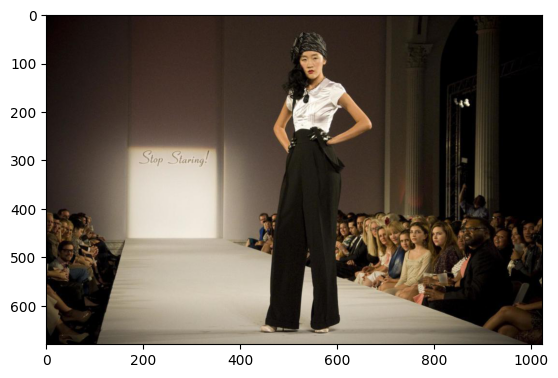

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
plt.imshow(Image.open("/content/images_20.jpg"))

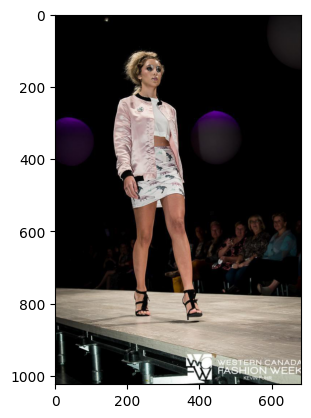

In [18]:
plt.imshow(Image.open("/content/images_41.jpg"))